# Cythonizing the point lens class
## Result: 
### (i) We obtain ___ speedup in the Wave optics regime,
### (ii) ___ speedup in the Quasi-Geometrical optics regime,
### (iii) ___ speedup in the Geometrical optics regime.



In [1]:
%load_ext cython

In [34]:
%%cython -a

# distutils: language = c++

import mpmath
from mpmath import hyp1f1

import cython
cimport libc.math
#scipy's gamma is long double so will use mpmath.gamma for cases where the former returns 0 )
#scipy's hyp1f1 doesn't support complex so will use mpmath.hyp1f1
from scipy.special.cython_special cimport gamma #, hyp1f1
cdef extern from "complex.h" namespace "std" nogil:
    long double complex exp(long double complex)
    long double real(long double complex z)
    long double imag(long double complex z)

import gmpy2
from gmpy2 import mpc    
gmpy2.set_context(gmpy2.context(real_prec=400,imag_prec=400))
gmpy2.get_context()

cdef double G_SI = 6.67430e-11     # (m^3/Kg/s^2)
cdef double C_SI = 299792458       # (m/s)
cdef double Msun_SI = 1.98847e+30  # (Kg)

# User Defined Classes
# cdef class point_lens_cython:
'''
A Cython module containing functions for studying microlensing due to an isolated point-mass lens. 
In such cases, two images are formed: one minima (type I) and one saddle (type II). 
'''

# image positions
cpdef double x_minima(double y):
    return (y+libc.math.sqrt(y**2.+4.))/2.

cpdef double x_saddle(double y):
    return (y-libc.math.sqrt(y**2.+4.))/2.

#image magnifications
@cython.cdivision(True)
cpdef double magification_minima(double y):
    return 1/2. + (y**2.+2.)/(2.*y*libc.math.sqrt(y**2.+4.))  

@cython.cdivision(True)
cpdef double magification_saddle(double y):
    return 1/2. - (y**2.+2.)/(2.*y*libc.math.sqrt(y**2.+4.))

#time delay between the two images
@cython.cdivision(True)
cpdef double time_delay_dimensionless(double y):
    return (y*libc.math.sqrt(y**2.+4.))/2. + libc.math.log((libc.math.sqrt(y**2.+4.)+y)/(libc.math.sqrt(y**2.+4.)-y))

@cython.cdivision(True)
cpdef double time_delay(double ml, double y, double zl=0):
    return (4.*G_SI*Msun_SI*ml*(1.+zl)/C_SI**3.)*((y*libc.math.sqrt(y**2.+4.))/2. + libc.math.log((libc.math.sqrt(y**2.+4.)+y)/(libc.math.sqrt(y**2+4)-y)))

# Geometric and Quasi Geometric approximations
cpdef double complex Fw_geometric_optics(double w, double y):
    return libc.math.sqrt(libc.math.fabs(magification_minima(y))) - 1j*libc.math.sqrt(libc.math.fabs(magification_saddle(y)))*exp(1j*w*time_delay_dimensionless(y))

@cython.cdivision(True)
cpdef double complex Fw_quasigeometric_optics(double w, double y):
    return Fw_geometric_optics(w,y) + (1j/(3.*w))*((4.*x_minima(y)**2.-1.)/(((x_minima(y)**2.+1.)**3.)*(x_minima(y)**2.-1.)))*libc.math.sqrt(libc.math.fabs(magification_minima(y))) + (1./(3*w))*((4.*x_saddle(y)**2.-1.)/(((x_saddle(y)**2.+1.)**3.)*(x_saddle(y)**2.-1.)))*libc.math.sqrt(libc.math.fabs(magification_saddle(y)))*exp(1j*w*time_delay_dimensionless(y)) 

# dimensionless frequency (w) in terms of dimensionfull frequency (f), w(f)
@cython.cdivision(True)
#@cython.boundscheck(False)
cpdef double w_of_f(double f, double ml, double zl=0):
    wf = f*8.*libc.math.pi*G_SI*ml*(1.+zl)*Msun_SI/C_SI**3.
    return wf

# dimensionfull frequency (f) in terms of dimensionless frequency (w), f(w)
@cython.cdivision(True)
cpdef double f_of_w(double w, double ml, double zl=0):
    fw = w * (C_SI**3) / (8.*libc.math.pi*G_SI*ml*(1.+zl)*Msun_SI)        
    return fw

cpdef double w_cutoff_geometric_optics_tolerance_0p1(double y, bint warn=True):
# returns wc(y) (cutoff w for a given y) such that w > wc gives relative error < 0.1 % when 
# geometric optics is used. Valid for y in range (0.01, 5.00)
    if 0.01 <= y <= 0.12:
        wc = 15112.5 - 52563.5*y
    elif 0.12 < y <= 1.5:
        wc = -34.08 - 12.84*(y**(-1)) + 114.33*(y**(-2)) + 0.89*(y**(-3)) 
    elif 1.5 < y < 5.01:
        wc = -15.02 + 18.25*y - 2.66*y**2
    else:
        if warn:
            print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
        if y > 5.01:
            wc = -15.02 + 18.25*y - 2.66*y**2
        if y < 0.01:
            wc = 15112.5 - 52563.5*y
    return wc


# same for Quasi Geometric approximation  
cpdef double w_cutoff_quasigeometric_optics_tolerance_0p1(double y, bint warn=True):
    if 0.01 <= y <= 5.01:
        wc = 9*(y**(-1)) + 0.04*(y**(-2))
    else:
        if warn:
            print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
        wc = 9*(y**(-1)) + 0.04*(y**(-2))
    return wc

#same for 1% relative error
cpdef double w_cutoff_geometric_optics_tolerance_1p0(double y, bint warn=True):
    if 0.01 <= y <= 0.071:
        wc = 16604 - 202686*y
    elif 0.071 < y <= 5.01:
        wc = 0.64 + 0.97*(y**(-1)) + 6*(y**(-2)) + 0.38*(y**(-3))  
    else:
        if warn:
            print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
        if y > 5.01:
            wc = 0.64 + 0.97*(y**(-1)) + 6*(y**(-2)) + 0.38*(y**(-3))  
        if y < 0.01:
            wc = 16604 - 202686*y
    return wc

cpdef double w_cutoff_quasigeometric_optics_tolerance_1p0(double y, bint warn=True):
    if 0.01 <= y <= 5.01:
        wc = 4*(y**(-1)) - libc.math.log(y)/5 
    else:
        if warn:
            print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
        wc = 4*(y**(-1)) - libc.math.log(y)/5 
    return wc


# Amplification Factor, F(w, y), for point lens using actual analytic formula. 
# It breaks down, or is difficult to compute, when the system approaches geometrical optics regime.
cpdef long double complex Fw_analytic(long double w, double y):
    cdef long double xm, pm, hp
    cdef long double complex hf, Ff, tmp_fac
    if w==0:
        return 1
    else:
        xm = (y+libc.math.sqrt(y*y + 4.))/2.
        pm = ((xm-y)**2)/2 - libc.math.log(xm)
        hp = libc.math.log(w/2.)-(2.*pm)
        tmp_fac = (libc.math.pi*w/4.)+1j*(hp*w/2.) 
        if real(tmp_fac) < 709:   # because e^709 is max value for long double; after which it just returns infinite
            h = exp(tmp_fac)
        else:    
            h = gmpy2.exp(tmp_fac)
        if w < 900:               # since gamma is strictly decreasing func, after roughly w~900, gamma val goes below e^308 and so long double return 0
            gm = gamma(1.-(1j*w/2.))
        else:
            gm = mpmath.gamma(1.-(1j*w/2.))       
        hf = hyp1f1((1j*w/2.),1., (1j*y*y*w/2.))

        # converting gm and hf to mpc objects
        if gm.imag>0:
            gm = mpc(str(gm.real) + '+' + str(gm.imag) + 'j')
        else:    
            gm = mpc(str(gm.real) + str(gm.imag) + 'j')

        if hf.imag>0:
            hf = mpc(str(hf.real) + '+' + str(hf.imag) + 'j')
        else:    
            hf = mpc(str(hf.real) + str(hf.imag) + 'j')  
        Ff = gmpy2.mul(h*gm, hf)   #gmpy is necessary for precision.
        return real(Ff)+1j*imag(Ff)  

# An efficient computation that uses our knowledge from the geometric optics limit. 
# It can handle any values.
cpdef double complex Fw_effective(double w, double y):
    wc_geo = w_cutoff_geometric_optics_tolerance_0p1(y)
    wc_Qgeo = w_cutoff_quasigeometric_optics_tolerance_0p1(y)
    if w < wc_Qgeo:
        return Fw_analytic(w,y)
    elif ((w>=wc_Qgeo)&(w<wc_geo)):
        return Fw_quasigeometric_optics(w,y)
    else:
        return Fw_geometric_optics(w,y)

cpdef double complex Ff_effective(double f, double ml, double y, double zl=0):
    w = w_of_f(f, ml, zl)
    return  Fw_effective(w, y)

/home/anuj/.cache/ipython/cython/_cython_magic_c6f38203c4c58efac008b0b367aa51e9.cpp: In function 'PyObject* __pyx_pw_46_cython_magic_c6f38203c4c58efac008b0b367aa51e9_25w_cutoff_geometric_optics_tolerance_1p0(PyObject*, PyObject*, PyObject*)':
/home/anuj/.cache/ipython/cython/_cython_magic_c6f38203c4c58efac008b0b367aa51e9.cpp:3859:33: warning: '__pyx_v_wc' may be used uninitialized in this function [-Wmaybe-uninitialized]
 3859 |   __pyx_t_3 = PyFloat_FromDouble(__pyx_t_1); if (unlikely(!__pyx_t_3)) __PYX_ERR(0, 109, __pyx_L1_error)
      |               ~~~~~~~~~~~~~~~~~~^~~~~~~~~~~
/home/anuj/.cache/ipython/cython/_cython_magic_c6f38203c4c58efac008b0b367aa51e9.cpp:3548:10: note: '__pyx_v_wc' was declared here
 3548 |   double __pyx_v_wc;
      |          ^~~~~~~~~~


In [45]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 22
mpl.rcParams['xtick.labelsize'] = 22.0
mpl.rcParams['ytick.labelsize'] = 22.0
mpl.rcParams['lines.markersize'] = 10.0
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Computer Modern'

ys = np.logspace(-2, np.log10(5), 100)

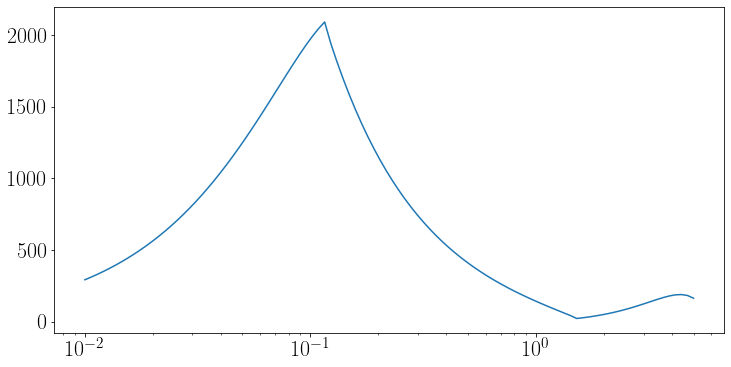

In [65]:
geo_tol_arr = np.array([w_cutoff_geometric_optics_tolerance_0p1(y) for y in ys])
td_arr = np.array([time_delay_dimensionless(y) for y in ys])
plt.plot(ys, geo_tol_arr*td_arr)
plt.xscale('log')
plt.show()

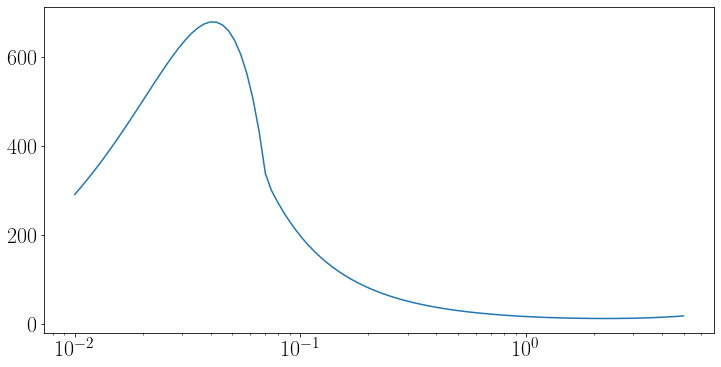

In [66]:
geo_tol_arr = np.array([w_cutoff_geometric_optics_tolerance_1p0(y) for y in ys])
td_arr = np.array([time_delay_dimensionless(y) for y in ys])
plt.plot(ys, geo_tol_arr*td_arr)
plt.xscale('log')
plt.show()

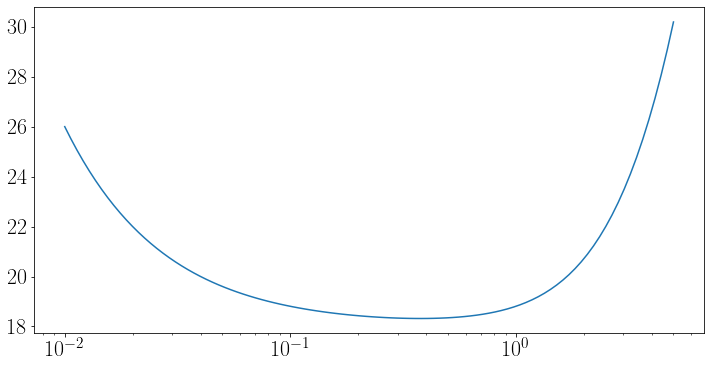

In [67]:
geo_tol_arr = np.array([w_cutoff_quasigeometric_optics_tolerance_0p1(y) for y in ys])
td_arr = np.array([time_delay_dimensionless(y) for y in ys])
plt.plot(ys, geo_tol_arr*td_arr)
plt.xscale('log')
plt.show()

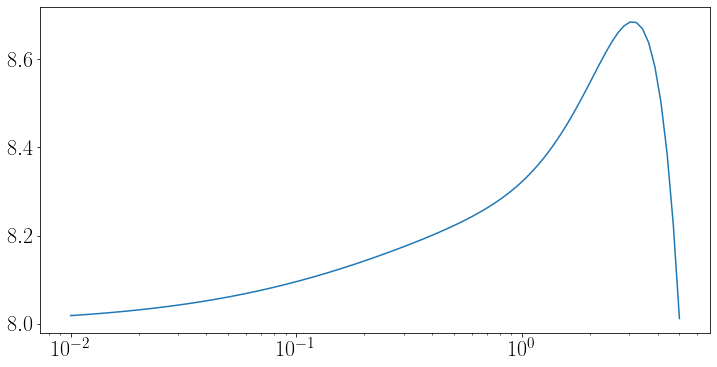

In [68]:
geo_tol_arr = np.array([w_cutoff_quasigeometric_optics_tolerance_1p0(y) for y in ys])
td_arr = np.array([time_delay_dimensionless(y) for y in ys])
plt.plot(ys, geo_tol_arr*td_arr)
# plt.plot(ys, geo_tol_arr)
plt.xscale('log')
plt.show()